In [1]:
import pandas as pd
import numpy as np
from yahoo_fin import stock_info as finance

# Retrieve OHLCV Stock Data

In [2]:
# Mock function to mimic the behavior of finance.get_data
def get_data(ticker, sdate, edate):
    # Assume this function returns a DataFrame similar to the one produced by finance.get_data
    # For demonstration, we're generating a DataFrame with a date range and mock data
    return finance.get_data(ticker, sdate, edate)


# Identify "Events" (e.g., Short Squeezes, Merger Announcements, etc.)

In [3]:
def identify_price_jumps(df, z_score_threshold=2, stability_threshold=1, lookback_period=90, lag_days_start=2, lag_days_end=5, 
                         include_negative_class=False, remove_duplicate_price_jump_dates=False):
    # Calculating daily price changes
    df['PriceChange'] = df['close'].pct_change()
    
    # Calculating rolling statistics
    rolling_mean = df['PriceChange'].rolling(window=lookback_period).mean()
    rolling_std = df['PriceChange'].rolling(window=lookback_period).std()
    
    # Identifying potential price jumps
    positive_results = []
    for i in range(lookback_period, len(df) - lag_days_end):
        current_z_score = (df.iloc[i]['PriceChange'] - rolling_mean[i]) / rolling_std[i]
        if abs(current_z_score) < stability_threshold:
            for lag_day in range(lag_days_start, lag_days_end+1):
                if i+lag_day < len(df):
                    future_price_change = df.iloc[i+lag_day]['PriceChange']
                    future_z_score = (future_price_change - rolling_mean[i+lag_day]) / rolling_std[i+lag_day]
                    if future_z_score > z_score_threshold:
                        positive_results.append({
                            'TriggerDate': df.index[i].date(),
                            'TriggerClose': df.iloc[i]['close'],
                            'PriceJumpDate': df.index[i+lag_day].date(),
                            'Close': df.iloc[i+lag_day]['close'],
                            'PriceJumpZScore': future_z_score,
                            'DaysAfterTrigger': lag_day,
                            'SignificantPriceJump': True,
                            'Ticker': df.iloc[0]['ticker']
                        })
                        break
                        
    # Convert positive results to DataFrame
    positive_results_df = pd.DataFrame(positive_results)

    # If remove_duplicate_price_jump_dates flag is set, remove duplicates
    if remove_duplicate_price_jump_dates:
        # Group by PriceJumpDate and randomly keep one record per group
        positive_results_df = positive_results_df.groupby('PriceJumpDate').apply(lambda x: x.sample(1)).reset_index(drop=True)


    # Sample negative class instances if required
    negative_results = []
    if include_negative_class:
        num_positive = len(positive_results_df)
        sampled_rows = df.iloc[lookback_period:len(df) - lag_days_end].sample(n=num_positive)
        for _, row in sampled_rows.iterrows():
            negative_results.append({
                'TriggerDate': row.name.date(),
                'TriggerClose': row['close'],
                'PriceJumpDate': None,  # No price jump date for negative class
                'Close': None,
                'PriceJumpZScore': None,
                'DaysAfterTrigger': None,
                'SignificantPriceJump': False,
                'Ticker': df.iloc[0]['ticker']
            })

    # Combine positive and negative results
    combined_results = pd.DataFrame(positive_results_df.to_dict('records') + negative_results).fillna(0)


    return combined_results

# Example usage
df = get_data('GME', '2019-01-01', '2023-11-15')
price_jumps_df = identify_price_jumps(df, z_score_threshold=2.5, stability_threshold=1, include_negative_class=True, remove_duplicate_price_jump_dates = True)
price_jumps_df.sample(5)


,TriggerDate,TriggerClose,PriceJumpDate,Close,PriceJumpZScore,DaysAfterTrigger,SignificantPriceJump,Ticker
39,2023-03-17,16.600000,0,0.000000,0.000000,0.0,False,GME
31,2021-04-19,41.092499,0,0.000000,0.000000,0.0,False,GME
33,2023-10-11,15.820000,0,0.000000,0.000000,0.0,False,GME
14,2021-08-19,38.224998,2021-08-24,52.572498,3.872633,3.0,True,GME
26,2022-07-20,39.687500,0,0.000000,0.000000,0.0,False,GME


# Retrieve Short Sale Volume Data

In [4]:
# Short sale volume

class ShortSaleVolume:
    
#     bucket = 'mads-capstone-2023' 
#     data_key = 'FINRA_Short_Sale_Data.csv' 
#     data_location = 's3://{}/{}'.format(bucket, data_key) 
    data_location = r'A:\FINRA_Short_Sale_Data2.csv'
    
    def __init__(self):
        self.has_downloaded = False 
    
    # Function to download data from S3
    def get_data(self):
        if not self.has_downloaded:
            self.df = pd.read_csv(self.data_location)
            self.df.drop(['Unnamed: 0'], axis = 1, inplace = True)
            self.df['shortvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['longvolume'] = self.df['totalvolume'] - self.df['shortvolume']
            self.df['short_ratio'] = 1 - self.df['short_ratio']
            self.has_downloaded = True
        else:
            pass
        
    def short_ratio(self, ticker):
        # Check if data has been downloaded locally
        self.get_data()
        
        # Return data for ticker 
        df_ = self.df[self.df['ticker'] == ticker].copy()
        df_['date'] = pd.to_datetime(df_['date'])
        df_.set_index('date', inplace=True)
        return df_

    
    def calculate_short_ratio_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]
        for period in periods:
            df[f'short_ratio_mean_{period}'] = df['short_ratio'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_ratio_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_ratio_mean_{periods[i]}'] / df[f'short_ratio_mean_{periods[j]}']
                    df[f'short_ratio_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_ratio_mean_{periods[j]}'] / df[f'short_ratio_mean_{periods[i]}']

        if include_roc:
            # print('working')
            for col in df.columns:
                if 'short_ratio_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_ratio_mean_' in col or ('roc' in col and 'short_ratio_mean_' in col)]]
        return result_df

    def calculate_short_exempt_means(self, ticker='GME', include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)
        periods = [1, 5, 10, 21, 42]

        df['short_exempt_percent'] = (df['shortexemptvolume'] / df['totalvolume'])

        for period in periods:
            df[f'short_exempt_percent_mean_{period}'] = df['short_exempt_percent'].rolling(window=period).mean()

        if include_diff:
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'short_exempt_percent_mean_{periods[i]}_div_mean_{periods[j]}'] = df[f'short_exempt_percent_mean_{periods[i]}'] / df[f'short_exempt_percent_mean_{periods[j]}']
                    df[f'short_exempt_percent_mean_{periods[j]}_div_mean_{periods[i]}'] = df[f'short_exempt_percent_mean_{periods[j]}'] / df[f'short_exempt_percent_mean_{periods[i]}']

        if include_roc:
            for col in df.columns:
                if 'short_exempt_percent_mean_' in col:
                    df[f'{col}_roc'] = df[col].pct_change() * 100

        result_df = df[[col for col in df.columns if 'short_exempt_percent_mean_' in col or ('roc' in col and 'short_exempt_percent_mean_' in col)]]
        return result_df
    
    def calculate_investment_values(self, ticker='GME', days=20, investment_amount=1_000_000, include_diff=False, include_roc=False):
        df = self.short_ratio(ticker)

        # Retrieve closing prices from finance API
        closing_prices = finance.get_data(ticker, df.index.min(), df.index.max())['close']
        
        # Merge closing prices with short ratio data
        df = df.merge(closing_prices, left_index=True, right_index=True, how='left')

        # Ensure short_exempt_percent column is calculated before its usage
        df['short_exempt_percent'] = df['shortexemptvolume'] / df['totalvolume']

        # Calculate net short volume and net short shares
        df['net_short_volume'] = df['shortvolume'] - df['longvolume']
        df['net_short_shares'] = investment_amount / df['close']

        # Calculate cumulative net short volume and short exempt volume
        df['cumulative_net_short'] = (df['net_short_volume'] * df['net_short_shares']).rolling(window=days).sum()
        df['cumulative_short_exempt'] = (df['short_exempt_percent'] * df['net_short_shares']).rolling(window=days).sum()

        # Calculate the cumulative values as a percent of total volume
        df['cumulative_net_short_percent'] = df['cumulative_net_short'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100
        df['cumulative_short_exempt_percent'] = df['cumulative_short_exempt'] / (df['totalvolume'] * df['net_short_shares']).rolling(window=days).sum() * 100

        if include_diff:
            periods = [1, 5, 10, 21, 42]
            for i in range(len(periods)):
                for j in range(i + 1, len(periods)):
                    df[f'cumulative_net_short_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_net_short_percent'].rolling(window=periods[i]).mean() / df['cumulative_net_short_percent'].rolling(window=periods[j]).mean()
                    df[f'cumulative_short_exempt_percent_{periods[i]}_div_{periods[j]}'] = df['cumulative_short_exempt_percent'].rolling(window=periods[i]).mean() / df['cumulative_short_exempt_percent'].rolling(window=periods[j]).mean()

        if include_roc:
            for col in ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']:
                df[f'{col}_roc'] = df[col].pct_change() * 100

        selected_cols = ['cumulative_net_short_percent', 'cumulative_short_exempt_percent']
        if include_diff or include_roc:
            selected_cols += [col for col in df.columns if 'cumulative_net_short_percent' in col or 'cumulative_short_exempt_percent' in col]

        return df[selected_cols]

# Example usage 
analysis = ShortSaleVolume()
df_gme_short_ratio = analysis.calculate_short_ratio_means('GME', include_roc = False)
df_gme_short_sale_exempt = analysis.calculate_short_exempt_means('GME', include_roc = False)
df_gme_investment_values = analysis.calculate_investment_values('GME', include_roc = False)


In [5]:
df_gme_short_ratio.dropna().head()

,short_ratio_mean_1,short_ratio_mean_5,short_ratio_mean_10,short_ratio_mean_21,short_ratio_mean_42
date,,,,,
2018-09-28,0.715327,0.590466,0.562471,0.510231,0.458547
2018-10-01,0.477881,0.543220,0.556017,0.516699,0.458230
2018-10-02,0.366158,0.535087,0.531209,0.519668,0.457416
2018-10-03,0.282883,0.498867,0.503887,0.512232,0.456949
2018-10-04,0.353930,0.439236,0.488570,0.507345,0.457152


# Retrieve Implied Volatility & Gamma

In [6]:
import psycopg2
import pandas as pd

class GreekAnalysis:
    def __init__(self):
        self.db_params = {
            'user': 'postgres',
            'password': '!Data2019!',
            'host': '127.0.0.1',
            'port': '5432',
            'database': 'options_data'
        }

    def get_greeks_data(self, ticker, greek_type):
        with psycopg2.connect(**self.db_params) as db_connection:
            db_connection.autocommit = True
            with db_connection.cursor() as cursor:
                select_query = "SELECT * FROM greeks WHERE ticker=%s AND GREEK=%s"
                cursor.execute(select_query, (ticker, greek_type))
                rows = cursor.fetchall()
                cols = ['TICKER', 'DATE', 'GREEK', 'INCREMENT', 'OPTION_TYPE', 'VALUE']
                df = pd.DataFrame(rows, columns= cols)#["ID", "DATE", "INCREMENT", "VALUE", "TICKER", "GREEK", "OPTION_TYPE"])
        return df

    def analyze_data(self, df, greek_type):
        merged_df = self._prepare_merged_dataframe(df, greek_type)
        merged_df[f'{greek_type}_Skew'] = merged_df[f'{greek_type}_Call'] / merged_df[f'{greek_type}_Put']
        merged_df[f'{greek_type}_Time_Spread'] = merged_df[f'{greek_type}_30'] / merged_df[f'{greek_type}_90']
        return merged_df[[f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']]

    def _prepare_merged_dataframe(self, df, greek_type):
        inc30_all = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'all')]
        inc30_call = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'call')]
        inc30_put = df[(df['INCREMENT'] == 30) & (df['OPTION_TYPE'] == 'put')]
        inc90_all = df[(df['INCREMENT'] == 90) & (df['OPTION_TYPE'] == 'all')]

        merged_df = pd.DataFrame(index=inc30_all['DATE'].unique())
        merged_df[f'{greek_type}_30'] = inc30_all.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Call'] = inc30_call.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_Put'] = inc30_put.groupby('DATE')['VALUE'].mean()
        merged_df[f'{greek_type}_90'] = inc90_all.groupby('DATE')['VALUE'].mean()

        return merged_df

    def _add_rolling_features(self, df, greek_type):
        periods = [1, 5, 10, 21, 42]
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            for period in periods:
                df[f'{col}_rolling_{period}'] = df[col].rolling(window=period).mean()
        return df

    def _add_z_score_features(self, df, greek_type):
        rolling_window = 90
        for col in [f'{greek_type}_30', f'{greek_type}_Skew', f'{greek_type}_Time_Spread']:
            df[f'{col}_z_score'] = (df[col] - df[col].rolling(window=rolling_window).mean()) / df[col].rolling(window=rolling_window).std()
        return df

    def get_analysis_for_ticker(self, ticker, greek_type='iv', include_rolling=False, include_z_score=False):
        df = self.get_greeks_data(ticker, greek_type)
        analysis_df = self.analyze_data(df, greek_type)
        if include_rolling:
            analysis_df = self._add_rolling_features(analysis_df, greek_type)
        if include_z_score:
            analysis_df = self._add_z_score_features(analysis_df, greek_type)
        return analysis_df.sort_index()

# Example usage:
greek_analysis = GreekAnalysis()
df_gme_iv = greek_analysis.get_analysis_for_ticker('GME', 'iv', include_rolling=True, include_z_score=True)
df_gme_gamma = greek_analysis.get_analysis_for_ticker('GME', 'gamma', include_rolling=True, include_z_score=True)


In [7]:
df_gme_iv.head()

,iv_30,iv_Skew,iv_Time_Spread,iv_30_rolling_1,iv_30_rolling_5,iv_30_rolling_10,iv_30_rolling_21,iv_30_rolling_42,iv_Skew_rolling_1,iv_Skew_rolling_5,...,iv_Skew_rolling_21,iv_Skew_rolling_42,iv_Time_Spread_rolling_1,iv_Time_Spread_rolling_5,iv_Time_Spread_rolling_10,iv_Time_Spread_rolling_21,iv_Time_Spread_rolling_42,iv_30_z_score,iv_Skew_z_score,iv_Time_Spread_z_score
2010-01-04,0.4419,0.805862,1.010057,0.4419,0.54350,0.71834,0.836514,0.829674,0.805862,0.878369,...,0.968342,NaN,1.010057,1.015171,1.006839,1.001040,NaN,-1.773873,NaN,NaN
2010-01-05,0.4634,0.814967,1.017790,0.4634,0.73178,0.80827,0.886681,0.855955,0.814967,0.955490,...,NaN,NaN,1.017790,1.008959,1.003776,0.999362,NaN,-1.793181,NaN,NaN
2010-01-06,0.4802,0.954152,1.030693,0.4802,0.81714,0.85907,0.911286,0.868069,0.954152,0.991332,...,NaN,NaN,1.030693,1.004018,1.001997,0.998452,NaN,-1.773551,NaN,NaN
2010-01-07,0.4442,1.056051,1.013924,0.4442,0.45474,0.67739,0.812090,0.818129,1.056051,0.888812,...,0.972545,NaN,1.013924,1.018584,1.008231,1.001718,NaN,-1.712117,NaN,NaN
2010-01-08,0.4586,0.787571,1.049428,0.4586,0.45042,0.63378,0.788186,0.829048,0.787571,0.855496,...,0.963819,NaN,1.049428,1.022331,1.013174,1.004401,NaN,-1.605780,NaN,NaN


In [8]:
class VolatilityAnalysis(GreekAnalysis):
    def __init__(self):
        super().__init__()
        self.sdate = '20160101'
        self.edate = '20231110'
        
    # Function to calculate HV for a given OHLCV DataFrame
    def calculate_hv(self, ohlcv_df, look_forward=30):
        # Calculate daily returns
        daily_returns = ohlcv_df['close'].pct_change()

        # Compute rolling standard deviation of daily returns
        rolling_std = daily_returns.rolling(window = look_forward).std()

        # HV is the annualized standard deviation
        hv = rolling_std * np.sqrt(252)

        return hv

    def compare_iv_hv(self, ticker, shift_hv = False):
        
        # Get ticker data
        ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
        
        # Pull IV30 data
        iv30_df = self.get_greeks_data(ticker, 'iv')
        iv30_df = iv30_df[(iv30_df['GREEK'] == 'iv') & (iv30_df['OPTION_TYPE'] == 'all') & (iv30_df['INCREMENT'] == 30)].copy()
        iv30_df['date'] = pd.to_datetime(iv30_df['DATE'])
        iv30_df.rename({'VALUE':'iv30'}, inplace = True, axis = 1)

        # Calculate HV
        hv_df = self.calculate_hv(ohlcv_df)

        # Align and compare IV30 and HV
        # Ensure iv30_df and hv_df have the same date index
        comparison_df = pd.DataFrame()
        comparison_df['IV30'] = iv30_df.set_index('date').sort_index()['iv30']
        
        # Are we shifting HV? 
        if shift_hv:
            comparison_df['HV'] = hv_df.shift(-30)  # Adjust as necessary
        else:
            comparison_df['HV'] = hv_df
        
        # Add to dataframe and return 
        comparison_df['IV_HV_Difference'] = comparison_df['IV30'] - comparison_df['HV']

        return comparison_df['IV_HV_Difference']
    
    def calculate_vwap(self, ohlcv_df, rolling_window = 90):  
        ohlcv_df['Typical_Price'] = (ohlcv_df['high'] + ohlcv_df['low'] + ohlcv_df['close']) / 3
        ohlcv_df['TP_Volume'] = ohlcv_df['Typical_Price'] * ohlcv_df['volume']

        # Calculate rolling TP_Volume and rolling volume
        ohlcv_df['Rolling_TP_Volume'] = ohlcv_df['TP_Volume'].rolling(window=rolling_window).sum()
        ohlcv_df['Rolling_Volume'] = ohlcv_df['volume'].rolling(window=rolling_window).sum()

        # Compute rolling VWAP
        ohlcv_df['VWAP'] = ohlcv_df['Rolling_TP_Volume'] / ohlcv_df['Rolling_Volume']

        # Calculate the percentage difference between close and VWAP
        ohlcv_df['vwap_close_pct'] = ohlcv_df['close'] / ohlcv_df['VWAP']

        return ohlcv_df

    def compare_price_to_vwap(self, ticker = None, ohlcv_df = None):
        
        # Optionally, grab data
        if not isinstance(ohlcv_df, pd.DataFrame):
            ohlcv_df = finance.get_data(ticker, self.sdate, self.edate)
            
        ohlcv_df = self.calculate_vwap(ohlcv_df)
        return ohlcv_df['vwap_close_pct']
    
# Example usage
price_iv_analysis = VolatilityAnalysis()
df_iv_hv = price_iv_analysis.compare_iv_hv('GME')
df_vwap = price_iv_analysis.compare_price_to_vwap('GME')

In [9]:
df_iv_hv.dropna()

date
2016-02-17    0.112270
2016-02-18    0.094677
2016-02-19    0.073292
2016-02-22    0.032936
2016-02-23    0.019996
                ...   
2023-11-03    0.158877
2023-11-06    0.177158
2023-11-07    0.184321
2023-11-08    0.239404
2023-11-09    0.260739
Name: IV_HV_Difference, Length: 1954, dtype: float64

# Retreive all Reddit Sentiment Data

In [10]:
import psycopg2
import pandas as pd

# Global variable to store the data
cached_df = None

def fetch_data_from_db():
    global cached_df

    # Check if the data is already fetched
    if cached_df is not None:
        return cached_df

    # Database connection parameters
    db_params = {
        'user': 'postgres',
        'password': 'Data2023',
        'host': 'mads-capstone.cmohac77hep9.eu-north-1.rds.amazonaws.com',
        'port': 5432,
        'database': 'mads'
    }

    # Connect to the database
    with psycopg2.connect(**db_params) as db_connection:
        db_connection.autocommit = True

        # Create a cursor object
        with db_connection.cursor() as cursor:
            # SQL query to fetch data
            select_query = "SELECT * FROM reddit_sentiment_by_date;"

            # Execute the query
            cursor.execute(select_query)

            # Fetch all the rows
            rows = cursor.fetchall()

            # Creating a list of records
            records = [list(row) for row in rows]

    # Create and cache the DataFrame
    cached_df = pd.DataFrame(records, columns=["id", "ticker", "cumm_overall_sentiment", "cumm_weighted_sentiment", "record_date"])
    cached_df = cached_df.drop('id', axis=1).set_index('ticker')
    return cached_df

def get_data_for_ticker(ticker, start_date, end_date):
    # Fetch the data if not already done
    df = fetch_data_from_db()

    # Convert date columns to datetime for proper filtering
    df['record_date'] = pd.to_datetime(df['record_date'])

    # Filter based on ticker and date range
    filtered_df = df[(df.index == ticker) & (df['record_date'] >= pd.to_datetime(start_date)) & (df['record_date'] <= pd.to_datetime(end_date))]

    return filtered_df.rename({'record_date':'date'}, axis = 1).set_index('date')

# Example usage
df = fetch_data_from_db() # This will fetch and cache the data
print(df.shape)
print(df.head())

# Get data for a specific ticker and date range
filtered_df = get_data_for_ticker('AAPL', '2018-01-01', '2022-01-01')
print(filtered_df)


(161976, 3)
        cumm_overall_sentiment  cumm_weighted_sentiment record_date
ticker                                                             
TSLA                   5.49375               -139.88380  2018-08-01
SQ                     3.44880                115.74475  2018-08-01
NVDA                   2.61225                105.96790  2018-08-01
MSFT                   2.04665                107.76055  2018-08-01
CC                     1.46725                 61.27800  2018-08-01
            cumm_overall_sentiment  cumm_weighted_sentiment
date                                                       
2018-08-01                -0.34485                107.06720
2018-08-02                 0.68670                -14.14135
2018-08-03                 0.34000                 26.18000
2018-08-04                -1.15320                 76.38400
2018-08-05                 1.21430                365.71740
...                            ...                      ...
2021-12-24                 0.000

# Create ticker universe from Russel 3000

In [11]:
import requests
from bs4 import BeautifulSoup

def return_etf_holdings(ticker = 'IWV'):

    headers = requests.utils.default_headers()
    headers['User-Agent'] = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'
    res = requests.get("https://www.zacks.com/funds/etf/%s/holding"%ticker,  headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    js = None
    for script in soup.find_all("script"):
        if "etf_holdings.formatted_data = " in str(script):
    #    if "etf_holdings" in str(script):
            js = str(script)
    holdings = []
    # for line in js.text.split("["):
    for line in js.split("["):
        if "rel=" in line:
            line_soup = BeautifulSoup(line, 'html.parser')
            #holding = line_soup.find("a")["alt"].strip('\\"')
            holding = line_soup.find('a')['rel'][0].strip('\\"')
            holdings.append(holding)

    return holdings

In [12]:
# Get all tickers

tickers = return_etf_holdings('VTI')
print('Qty of tickers: ', len(tickers))

# Isolate for only tickers that are commonly mentioned on reddit
reddit_tickers = df[df.index.value_counts() > 50].index.unique().tolist()
reddit_tickers = [x for x in tickers if x in reddit_tickers]
reddit_tickers.append('BB')
print('Qty of reddit tickers: ', len(reddit_tickers))

# Check for meme stocks
for tic in ['AMC', 'GME']:
    if tic in reddit_tickers:
        print('{} in ticker universe'.format(tic))
    else:
        print('{} not in ticker universe'.format(tic))

Qty of tickers:  3703
Qty of reddit tickers:  542
AMC in ticker universe
GME in ticker universe


<ipython-input-12-112bf9522a81>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reddit_tickers = df[df.index.value_counts() > 50].index.unique().tolist()


In [13]:
# Merge additional data into price_jumps_df
def merge_additional_data(price_jumps_df, additional_dfs):
    for additional_df in additional_dfs:
        # Convert TriggerDate to datetime for merging
        price_jumps_df['TriggerDate'] = pd.to_datetime(price_jumps_df['TriggerDate'])
        
        # Merge each additional dataframe
        price_jumps_df = price_jumps_df.merge(additional_df, left_on='TriggerDate', right_index=True, how='left')
    
    return price_jumps_df

In [14]:
# # Pull all data and 

# from tqdm import tqdm
# sdate = '20180816'
# edate = '20230101'

# df_repo = []
# for ticker in tqdm(reddit_tickers):
    
#     try:
#         # Get data
#         df_data = get_data(ticker, sdate, edate)

#         # Calc positive and negative classes
#         price_jumps_df = identify_price_jumps(df_data, z_score_threshold=2.5, stability_threshold=1, include_negative_class=True, remove_duplicate_price_jump_dates = False)

#         # Get other data
#         df_short_ratio = analysis.calculate_short_ratio_means(ticker, include_diff=True, include_roc=True)
#         df_short_sale_exempt = analysis.calculate_short_exempt_means(ticker, include_diff=True, include_roc=True)
#         df_investment_values = analysis.calculate_investment_values(ticker, include_diff=True, include_roc=True)

#         df_iv = greek_analysis.get_analysis_for_ticker(ticker, 'iv', include_rolling = True, include_z_score = True)
#         df_gamma = greek_analysis.get_analysis_for_ticker(ticker, 'gamma', include_rolling = True, include_z_score = True)

#         df_iv_hv = price_iv_analysis.compare_iv_hv(ticker)
#         df_vwap = price_iv_analysis.compare_price_to_vwap(ticker)
        
#         # Get data for a specific ticker and date range
#         df_reddit_sent = get_data_for_ticker(ticker, sdate, edate)

#         # Merge datasets together
#         additional_dfs = [df_short_ratio, df_short_sale_exempt, df_investment_values, df_iv, df_gamma, df_iv_hv, df_vwap, df_reddit_sent]
#         for df_ in additional_dfs:
#             df_.index = pd.to_datetime(df_.index)
#         merged_df = merge_additional_data(price_jumps_df, additional_dfs)

#         # Save to repo and continue
#         df_repo.append(merged_df)
        
#     except Exception as e:
#         print(ticker, type(e), e)

In [15]:
# # Merge together and save locally
# merged_df = pd.concat(df_repo).reset_index(drop = True)

# # Forward fill the reddit sentiment columns (but only a week)
# merged_df["cumm_overall_sentiment"] = merged_df["cumm_overall_sentiment"].fillna(method='ffill', limit=5, inplace=True)
# merged_df["cumm_weighted_sentiment"] = merged_df["cumm_weighted_sentiment"].fillna(method='ffill', limit=5, inplace=True)

# # Save to local (for future use)
# # merged_df.to_csv('capstone_merged_data.csv.gz', compression = 'gzip')


# print(merged_df.shape)
# merged_df.head()

In [16]:
merged_df = pd.read_csv('capstone_merged_data.csv.gz').drop('Unnamed: 0', axis = 1)
merged_df['TriggerDate'] = pd.to_datetime(merged_df['TriggerDate'])
merged_df.head()

,TriggerDate,TriggerClose,PriceJumpDate,Close,PriceJumpZScore,DaysAfterTrigger,SignificantPriceJump,Ticker,short_ratio_mean_1,short_ratio_mean_5,...,gamma_Time_Spread_rolling_10,gamma_Time_Spread_rolling_21,gamma_Time_Spread_rolling_42,gamma_30_z_score,gamma_Skew_z_score,gamma_Time_Spread_z_score,IV_HV_Difference,vwap_close_pct,cumm_overall_sentiment,cumm_weighted_sentiment
0,2019-01-23,38.480000,2019-01-30,41.312500,2.697944,5.0,True,AAPL,0.415736,0.421091,...,0.878052,0.863128,0.869070,0.411110,-0.526687,0.164683,-0.056875,0.819800,NaN,NaN
1,2019-01-24,38.174999,2019-01-30,41.312500,2.697944,4.0,True,AAPL,0.451949,0.434423,...,0.866820,0.866538,0.868311,-0.029487,0.027305,0.141108,-0.050175,0.816241,NaN,NaN
2,2019-01-28,39.075001,2019-01-30,41.312500,2.697944,2.0,True,AAPL,0.413302,0.429676,...,0.817029,0.850693,0.864172,0.197023,-0.434071,0.075766,0.044062,0.840713,NaN,NaN
3,2020-02-26,73.162498,2020-03-02,74.702499,4.767875,3.0,True,AAPL,0.599268,0.653821,...,1.061761,0.876753,0.841714,-1.871178,1.762297,0.431210,0.117805,1.014967,NaN,NaN
4,2020-03-06,72.257500,2020-03-10,71.334999,3.040353,2.0,True,AAPL,0.595604,0.566061,...,1.098821,1.035846,0.905523,-1.626186,1.614886,1.621837,0.030362,0.996209,NaN,NaN


# Train initial Logistic Regression model

#### Use of TimeSeriesSplit to prevent lookahead bias in time series data

C:\Users\willi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\willi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

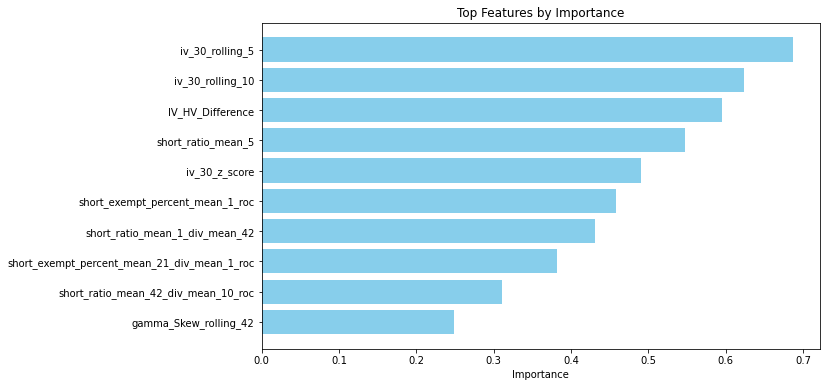

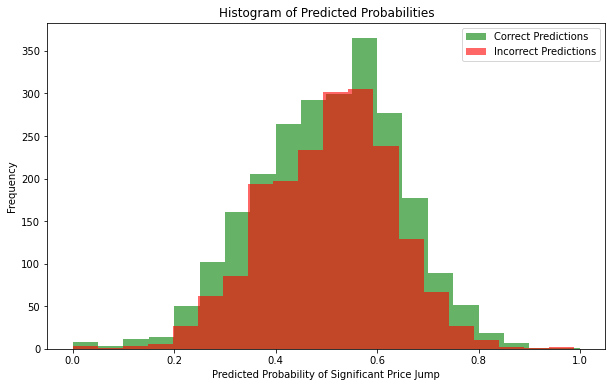

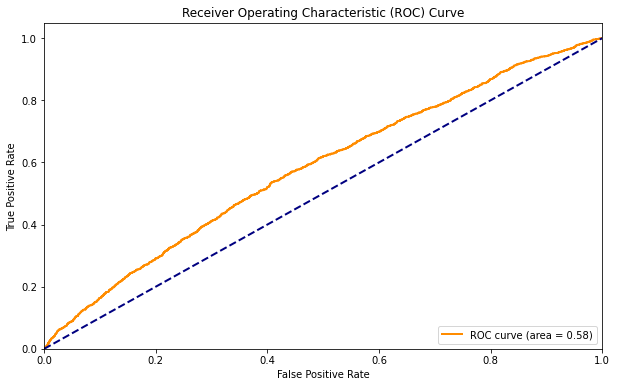

Overall accuracy: 0.59 +/- 0.03


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming your DataFrame is named 'merged_df'
# Handle missing values (if any)
merged_df.fillna(0, inplace=True)
merged_df.replace([np.inf, -np.inf], 0, inplace=True)

# Feature selection: Choose columns that are relevant as features
features = merged_df.columns[8:].tolist()

# Extract the features and labels
X = merged_df[features]
y = merged_df['SignificantPriceJump']

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits

# Initialize an array to store the coefficients
coefficients = np.zeros((tscv.n_splits, len(features)))

# Initialize variables to store evaluation metrics
accuracies = []
fpr_list = []
tpr_list = []
thresholds_list = []

# Model Training and Evaluation in a Cross-Validated manner
for i, (train_index, test_index) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Store the coefficients
    coefficients[i, :] = model.coef_

    # Model Evaluation
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

    # Calculate ROC curve and AUC for this fold
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresholds_list.append(thresholds)

    # Calculate accuracy for this fold
    accuracies.append(accuracy_score(y_test, y_pred))
    
    # Store evaluation metrics for the last fold for plotting
    if i == tscv.n_splits - 1:
        last_y_test = y_test
        last_y_pred = y_pred
        last_y_proba = y_proba

# Average the coefficients over all splits
avg_coefficients = np.mean(coefficients, axis=0)

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': avg_coefficients})

# Sort the features by importance
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Create a bar chart visualization for the most valuable features
top_features = feature_importances.head(10)  # Adjust the number you want to display
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='skyblue')
plt.xlabel('Importance')
plt.title('Top Features by Importance')
plt.show()

# Plot histogram of predicted probabilities for the last fold with correct and incorrect predictions
plt.figure(figsize=(10, 6))
# Correct predictions
correct_indices = last_y_test == last_y_pred
plt.hist(last_y_proba[correct_indices], bins=20, color='green', alpha=0.6, label='Correct Predictions')
# Incorrect predictions
incorrect_indices = ~correct_indices
plt.hist(last_y_proba[incorrect_indices], bins=20, color='red', alpha=0.6, label='Incorrect Predictions')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Significant Price Jump')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot ROC Curve for the last fold
plt.figure(figsize=(10, 6))
plt.plot(fpr_list[-1], tpr_list[-1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr_list[-1], tpr_list[-1]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print overall accuracy (mean over all folds)
print(f"Overall accuracy: {np.mean(accuracies):.2f} +/- {np.std(accuracies):.2f}")


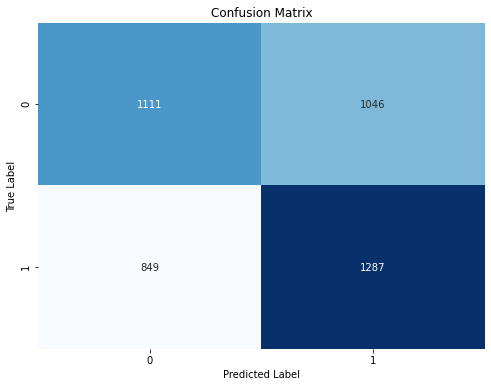

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

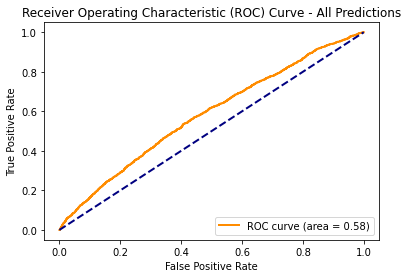

In [19]:
from sklearn.metrics import roc_curve, auc

# Assuming `model` is your trained classifier and `X_test` is your test data
probabilities = model.predict_proba(X_test)

# Compute ROC curve and AUC for all predictions
fpr_all, tpr_all, _ = roc_curve(y_test, probabilities[:, 1])
roc_auc_all = auc(fpr_all, tpr_all)

# Plot ROC curve
plt.figure()
plt.plot(fpr_all, tpr_all, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_all)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - All Predictions')
plt.legend(loc="lower right")
plt.show()

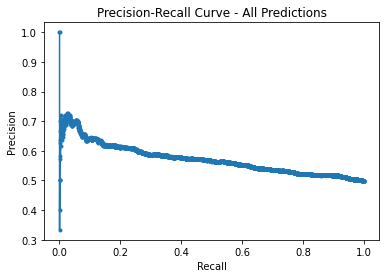

In [20]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve for all predictions
precision_all, recall_all, _ = precision_recall_curve(y_test, probabilities[:, 1])

# Plot the precision-recall curve
plt.plot(recall_all, precision_all, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - All Predictions')
plt.show()

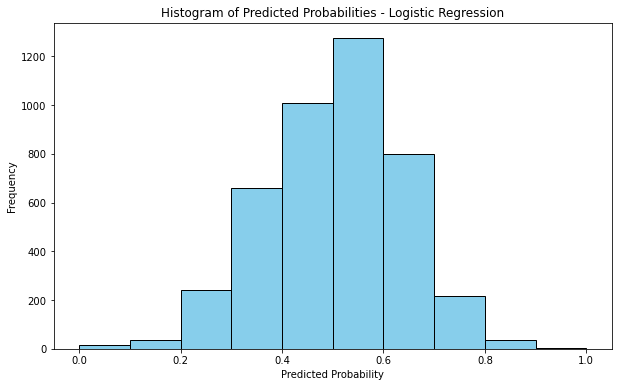

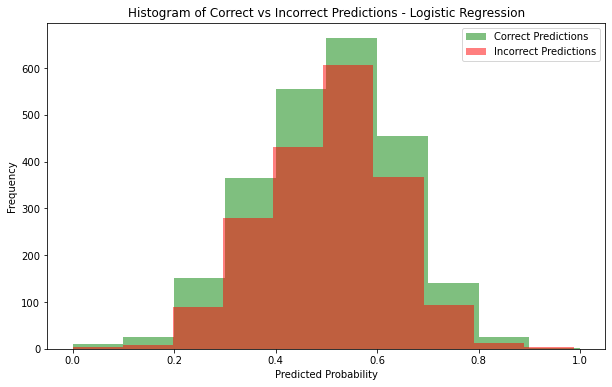

In [21]:
# Predict probabilities for the test data
probabilities_log_reg = model.predict_proba(X_test)[:, 1]

# Plot histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(probabilities_log_reg, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Predicted Probabilities - Logistic Regression')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Determine correct and incorrect predictions
correct_predictions = (probabilities_log_reg >= 0.5) == y_test
incorrect_predictions = (probabilities_log_reg >= 0.5) != y_test

# Plot histogram of correct vs incorrect predictions
plt.figure(figsize=(10, 6))
plt.hist(probabilities_log_reg[correct_predictions], bins=10, color='green', alpha=0.5, label='Correct Predictions')
plt.hist(probabilities_log_reg[incorrect_predictions], bins=10, color='red', alpha=0.5, label='Incorrect Predictions')
plt.title('Histogram of Correct vs Incorrect Predictions - Logistic Regression')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Are we able to improve the model through parameter tuning?

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assuming your DataFrame is named 'merged_df'
# Handle missing values (if any)
merged_df.fillna(0, inplace=True)
merged_df.replace([np.inf, -np.inf], 0, inplace=True)

# Feature selection: Choose columns that are relevant as features
features = merged_df.columns[8:].tolist()

# Extract the features and labels
X = merged_df[features]
y = merged_df['SignificantPriceJump']

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time Series Cross Validation setup
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits

# Define the model and parameters for Grid Search
model = LogisticRegression(n_jobs = -1)  # Set max_iter on the estimator if needed
param_grid = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Norms for penalization
    'solver': ['liblinear'],  # 'liblinear' works well with l1 and l2 penalties
    # 'max_iter': [100, 200, 300]  # Example if you want to vary max_iter
}

# Create Grid Search object without max_iter
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           n_jobs=-1, cv=tscv, scoring='f1', verbose=1)


# Perform the Grid Search
grid_search.fit(X_scaled, y)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluation with the best model
y_pred = best_model.predict(X_scaled)  # You may want to split the data again if needed
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

# Print the best parameters
print(f"Best parameters: {best_params}")

# Store the coefficients of the best model
coefficients = best_model.coef_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': coefficients.flatten()})

# Sort the features by importance
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importances)


Fitting 5 folds for each of 14 candidates, totalling 70 fits


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\willi\anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\willi\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 557, in run
    result_item, is_broken, bpe = self.wait_result_broken_or_wakeup()
  File "C:\Users\willi\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 611, in wait_result_broken_or_wakeup
    ready = wait(readers + worker_sentinels)
  File "C:\Users\willi\anaconda3\lib\multiprocessing\connection.py", line 879, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
  File "C:\Users\willi\anaconda3\lib\multiprocessing\connection.py", line 811, in _exhaustive_wait
    res = _winapi.WaitForMultipleObjects(L, False, timeout)
ValueError: need at most 63 handles, got a sequence of length 65


# Model Accuracy for High Confidence Predictions 

C:\Users\willi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       False       0.65      0.74      0.69       294
        True       0.77      0.70      0.73       378

    accuracy                           0.71       672
   macro avg       0.71      0.72      0.71       672
weighted avg       0.72      0.71      0.72       672

[[217  77]
 [115 263]]
Accuracy: 0.71


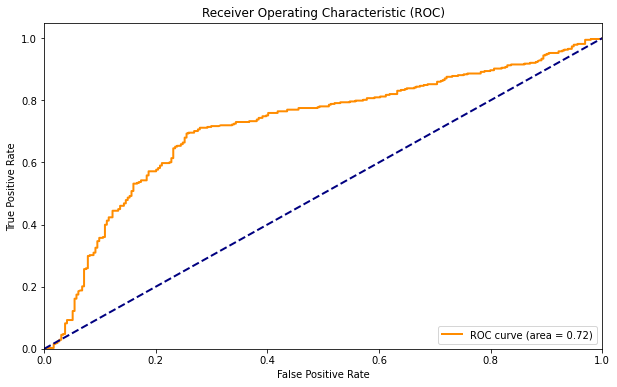

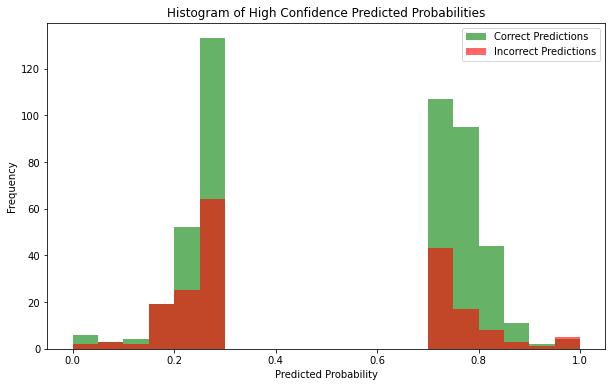

Confusion Matrix:
[[217  77]
 [115 263]]


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline for scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict probabilities on the test data
probabilities = pipeline.predict_proba(X_test)

# Filter predictions based on confidence
high_confidence_filter = (probabilities[:, 1] > 0.7) | (probabilities[:, 1] < 0.3)
filtered_y_test = y_test[high_confidence_filter]
filtered_probabilities = probabilities[high_confidence_filter]

# Predict labels for the high confidence predictions
filtered_predictions = (filtered_probabilities[:, 1] > 0.5).astype(int)

# Evaluation metrics for the filtered predictions
print(classification_report(filtered_y_test, filtered_predictions))
print(confusion_matrix(filtered_y_test, filtered_predictions))
print(f"Accuracy: {accuracy_score(filtered_y_test, filtered_predictions):.2f}")

# For ROC Curve, we need the probabilities and the true labels of the high confidence predictions
fpr, tpr, thresholds = roc_curve(filtered_y_test, filtered_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Plot histogram of predicted probabilities with correct and incorrect predictions
correct_predictions = filtered_y_test == filtered_predictions
plt.figure(figsize=(10, 6))
plt.hist(filtered_probabilities[correct_predictions, 1], bins=20, color='green', alpha=0.6, label='Correct Predictions')
plt.hist(filtered_probabilities[~correct_predictions, 1], bins=20, color='red', alpha=0.6, label='Incorrect Predictions')
plt.title('Histogram of High Confidence Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print Confusion Matrix for high confidence predictions
print("Confusion Matrix:")
print(confusion_matrix(filtered_y_test, filtered_predictions))


# Unsupervised 

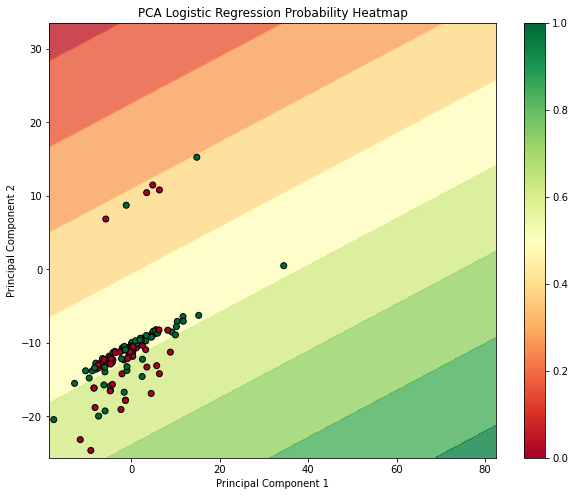

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Assuming your DataFrame and y are defined as before

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train logistic regression on the first two principal components
model = LogisticRegression()
model.fit(X_pca, y)

# Predict probabilities for the observations
probabilities = model.predict_proba(X_pca)

# Filter out the predictions where the probability of being the positive class is > 70%
# or the probability of being the negative class is < 30%
high_confidence_filter = (probabilities[:, 1] > 0.52) | (probabilities[:, 0] > 0.52)
X_pca_filtered = X_pca[high_confidence_filter]
y_filtered = y[high_confidence_filter]

# Create a mesh grid for the heatmap
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict probabilities on the mesh grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  # Probability of class 1
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlGn)
plt.scatter(X_pca_filtered[:, 0], X_pca_filtered[:, 1], c=y_filtered, edgecolors='k', cmap=plt.cm.RdYlGn)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Logistic Regression Probability Heatmap')
plt.colorbar()
plt.show()


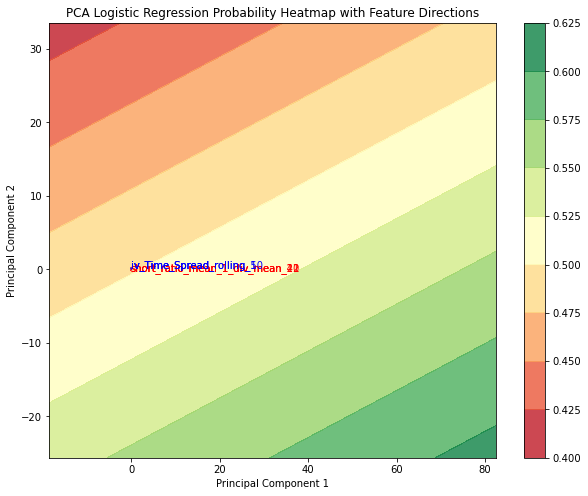

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Assuming your DataFrame and y are defined as before

# Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train logistic regression on the first two principal components
model = LogisticRegression()
model.fit(X_pca, y)

# Create a mesh grid for the heatmap
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict probabilities on the mesh grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  # Probability of class 1
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlGn)

# Overlay the vectors for the top features
# Select top features based on contribution to PCs
feature_vectors = pca.components_.T
top_features = np.argsort(np.abs(feature_vectors), axis=0)[-3:, :]  # Select top 3 features for each PC

for i, idx in enumerate(top_features[:, 0]):  # Loop over top features for PC1
    plt.arrow(0, 0, feature_vectors[idx, 0], feature_vectors[idx, 1], 
              color='r', alpha=0.5, head_width=0.02)
    plt.text(feature_vectors[idx, 0] * 1.15, feature_vectors[idx, 1] * 1.15, 
             features[idx], color='r')

for i, idx in enumerate(top_features[:, 1]):  # Loop over top features for PC2
    plt.arrow(0, 0, feature_vectors[idx, 0], feature_vectors[idx, 1], 
              color='b', alpha=0.5, head_width=0.02)
    plt.text(feature_vectors[idx, 0] * 1.15, feature_vectors[idx, 1] * 1.15, 
             features[idx], color='b')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Logistic Regression Probability Heatmap with Feature Directions')
plt.colorbar()
plt.show()


In [49]:
!pip install adjustText


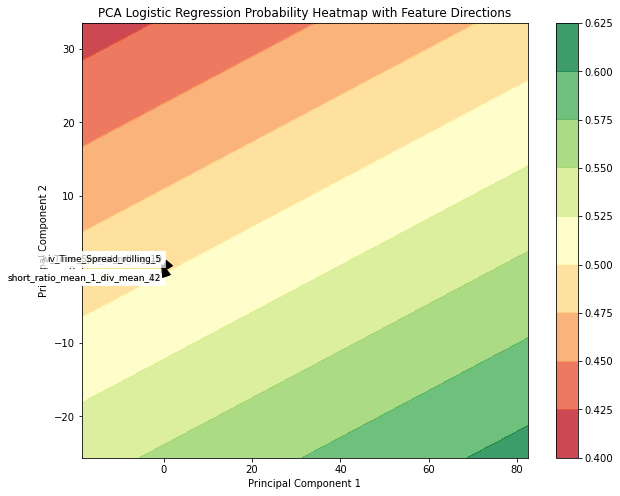

In [45]:
# ... [other parts of the code] ...

# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlGn)

# Overlay the vectors for the top features
# Select top features based on contribution to PCs
feature_vectors = pca.components_.T * 3  # Adjust if necessary
top_features = np.argsort(np.abs(feature_vectors), axis=0)[-3:]  # Select top 3 features for each PC

# Plot the arrows for the top features
for idx in top_features.flatten():
    # Dynamically adjust the text position based on the arrow direction
    text_x = feature_vectors[idx, 0] * 1.15
    text_y = feature_vectors[idx, 1] * 1.15
    horizontalalignment = 'left' if feature_vectors[idx, 0] > 0 else 'right'
    verticalalignment = 'bottom' if feature_vectors[idx, 1] > 0 else 'top'
    
    plt.annotate('', xy=(feature_vectors[idx, 0], feature_vectors[idx, 1]), xytext=(0, 0),
                 arrowprops=dict(facecolor='black', shrink=0, width=0.5, headwidth=8))
    plt.text(text_x, text_y, features[idx], color='black',
             ha=horizontalalignment, va=verticalalignment,
             fontsize=9, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Logistic Regression Probability Heatmap with Feature Directions')
plt.colorbar()
plt.show()


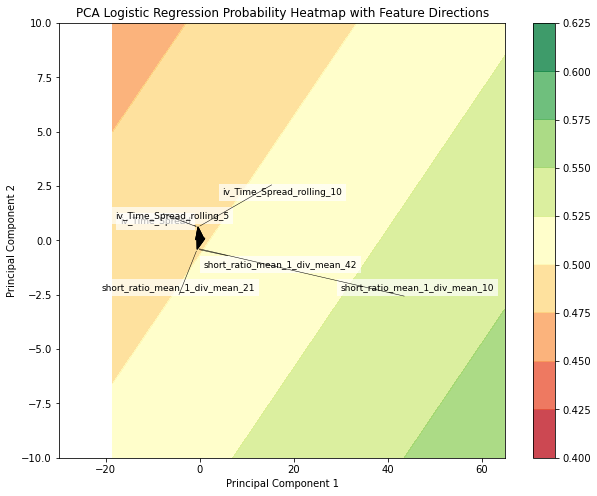

In [52]:
from adjustText import adjust_text

# ... [your PCA and logistic regression code] ...

# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlGn)

# Overlay the vectors for the top features
feature_vectors = pca.components_.T * 3  # Scale the arrows to be visible
top_features = np.argsort(np.abs(feature_vectors), axis=0)[-3:]  # Select top 3 features for each PC

texts = []  # Store the text instances here
for idx in top_features.flatten():
    plt.annotate('', xy=(feature_vectors[idx, 0], feature_vectors[idx, 1]), xytext=(0, 0),
                 arrowprops=dict(facecolor='black', shrink=0, width=0.5, headwidth=8))
    # Add text with background for better visibility
    text = plt.text(feature_vectors[idx, 0], feature_vectors[idx, 1], features[idx], 
                    ha='center', va='center', fontsize=9,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    texts.append(text)

# Use adjust_text to automatically spread apart text
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.xlim(-20, 65)
plt.ylim(-10, 10)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Logistic Regression Probability Heatmap with Feature Directions')
plt.colorbar()
plt.show()
